<a href="https://colab.research.google.com/github/Hiromitsu4676/Pytorch/blob/main/face_detection_Faster_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 210 kB 55.5 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 75 kB 4.8 MB/s 
     |████████████████████████████████| 113 kB 50.9 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 150 kB 44.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=11bd5e623382fe09e53c268920e71ce293c045a6e817e9e722649c5a5b821702
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import optuna
from torchvision import transforms
from PIL import Image
import xml.etree.ElementTree as ET 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
#エラー対処
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [17]:
class Xml2List(object):
    
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, xml_path):
        
        ret = []
        
        xml = ET.parse(xml_path).getroot()
        
        for size in xml.iter("size"):
          
            width = float(size.find("width").text)
            height = float(size.find("height").text)
                
        for obj in xml.iter("object"):
            
            difficult = int(obj.find("difficult").text)
            if difficult == 1:
                continue
                
            bndbox = [width, height]
            
            name = obj.find("name").text.lower().strip() 
            bbox = obj.find("bndbox") 
            
            pts = ["xmin", "ymin", "xmax", "ymax"]
            
            for pt in pts:
                
                cur_pixel =  float(bbox.find(pt).text)
                    
                bndbox.append(cur_pixel)
                
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)
            
            ret += [bndbox]
            
        return np.array(ret) # [width, height, xmin, ymin, xamx, ymax, label_idx]

In [18]:
#trainのanotationの読み込み
xml_paths = glob.glob("./drive/MyDrive/Pytorch/privateDataset/xml_resize/*.xml")
classes = ["saito", "ohnaka","doi",'sugai','suzuki']
    
transform_anno = Xml2List(classes)

df = pd.DataFrame(columns=["image_id", "width", "height", "xmin", "ymin", "xmax", "ymax", "class"])

for path in xml_paths:
    image_id = path.split("/")[-1].split(".")[0]
    # image_id = path.split("\\")[-1].split(".")[0]
    bboxs = transform_anno(path)

    for bbox in bboxs:
        tmp = pd.Series(bbox, index=["width", "height", "xmin", "ymin", "xmax", "ymax", "class"])
        tmp["image_id"] = image_id
        df = df.append(tmp, ignore_index=True)

df = df.sort_values(by="image_id", ascending=True)


#valのanotationの読み込み
xml_paths=glob.glob("./drive/MyDrive/Pytorch/privateDataset/xml_resize/*.xml")

classes = ["saito", "ohnaka","doi",'sugai','suzuki']


transform_anno = Xml2List(classes)

df_val = pd.DataFrame(columns=["image_id", "width", "height", "xmin", "ymin", "xmax", "ymax", "class"])

for path in xml_paths:
    image_id = path.split("/")[-1].split(".")[0]
    # image_id = path.split("\\")[-1].split(".")[0]
    bboxs = transform_anno(path)

    for bbox in bboxs:
        tmp = pd.Series(bbox, index=["width", "height", "xmin", "ymin", "xmax", "ymax", "class"])
        tmp["image_id"] = image_id
        df_val = df_val.append(tmp, ignore_index=True)

df_val = df_val.sort_values(by="image_id", ascending=True)

In [19]:
# 背景のクラス（0）が必要のため、dog, cat のラベルは1スタートにする
df["class"] = df["class"] + 1

In [20]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, image_dir):
        
        super().__init__()
        
        self.image_ids = df["image_id"].unique()
        self.df = df
        self.image_dir = image_dir
        
    def __getitem__(self, index):
 
        transform = transforms.Compose([
                                        transforms.ToTensor()
        ])

        # 入力画像の読み込み
        image_id = self.image_ids[index]
        image = Image.open(f"{self.image_dir}/{image_id}.jpg")
        image = transform(image)
        
        # アノテーションデータの読み込み
        records = self.df[self.df["image_id"] == image_id]
        boxes = torch.tensor(records[["xmin", "ymin", "xmax", "ymax"]].values.astype(np.float32), dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        labels = torch.tensor(records["class"].values.astype(np.int64), dtype=torch.int64)
        
        iscrowd = torch.zeros((records.shape[0], ), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"]= labels
        target["image_id"] = torch.tensor([index])
        target["area"] = area
        target["iscrowd"] = iscrowd


        return image, target, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [21]:
image_dir1="./drive/MyDrive/Pytorch/privateDataset/img_resize"
dataset = MyDataset(df, image_dir1)

image_dir2="./drive/MyDrive/Pytorch/privateDataset/img_resize"
dataset_val = MyDataset(df_val, image_dir2)

In [27]:
#データのロード
torch.manual_seed(2020)

train=dataset
val=dataset_val

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=False, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=10, shuffle=False, collate_fn=collate_fn)

In [10]:
# # 訓練データをdatasetsからダウンロード
# training_data = datasets.FashionMNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=ToTensor(),

In [11]:
# batch_size = 1
# train_dataloader = DataLoader(training_data, batch_size=batch_size)

In [12]:
#モデルの作成
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)####True
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
# model.to(device)
# model.cuda()

##注意　クラス数＋１
num_classes = (len(classes)) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
##学習
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 50

#GPUのキャッシュクリア
torch.cuda.empty_cache()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.cuda()

model.train()#学習モードに移行
for epoch in range(num_epochs):

    for i, batch in enumerate(train_dataloader):

        images, targets, image_ids = batch#####　batchはそのミニバッジのimage、tagets,image_idsが入ってる

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        ##学習モードでは画像とターゲット（ground-truth）を入力する
        ##返り値はdict[tensor]でlossが入ってる。（RPNとRCNN両方のloss）
        loss_dict= model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if (i+1) % 5 == 0:
          print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}")  


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch #1 Iteration #5 loss: 1.7042266130447388
epoch #1 Iteration #10 loss: 1.143702745437622
epoch #1 Iteration #15 loss: 0.7004926800727844
epoch #2 Iteration #5 loss: 0.24203453958034515
epoch #2 Iteration #10 loss: 0.5471152663230896
epoch #2 Iteration #15 loss: 0.8122642040252686
epoch #3 Iteration #5 loss: 0.18766875565052032
epoch #3 Iteration #10 loss: 0.4933916926383972
epoch #3 Iteration #15 loss: 0.5006148815155029
epoch #4 Iteration #5 loss: 0.2260541319847107
epoch #4 Iteration #10 loss: 0.41681787371635437
epoch #4 Iteration #15 loss: 0.4166427552700043
epoch #5 Iteration #5 loss: 0.19206053018569946
epoch #5 Iteration #10 loss: 0.4823290705680847
epoch #5 Iteration #15 loss: 0.4279913008213043
epoch #6 Iteration #5 loss: 0.18367797136306763
epoch #6 Iteration #10 loss: 0.413194477558136
epoch #6 Iteration #15 loss: 0.3996821641921997
epoch #7 Iteration #5 loss: 0.17250296473503113
epoch #7 Iteration #10 loss: 0.37609854340553284
epoch #7 Iteration #15 loss: 0.38813596963

ohnaka
sugai
ohnaka
saito
saito
saito
saito
ohnaka
saito
suzuki
saito
saito
sugai


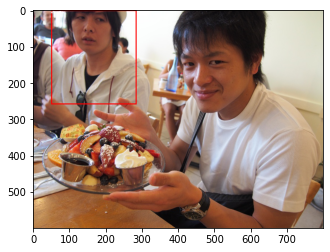

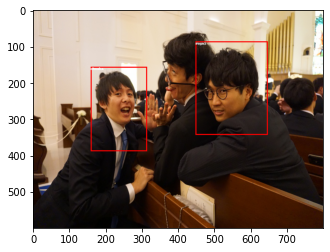

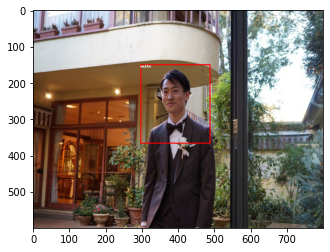

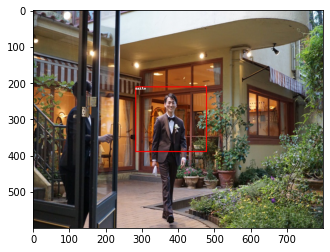

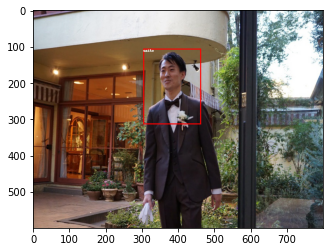

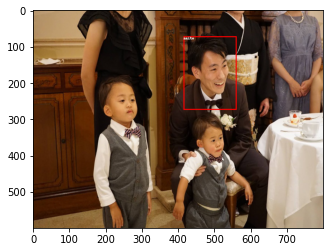

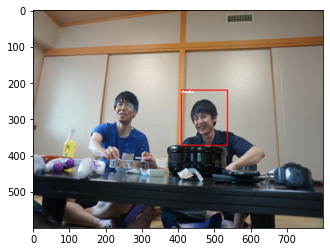

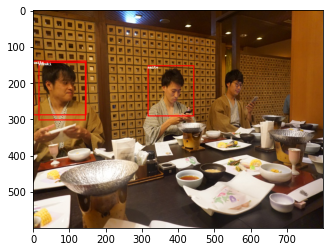

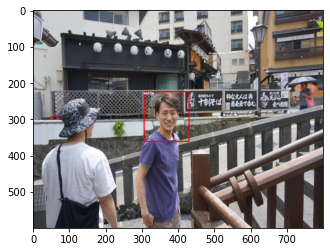

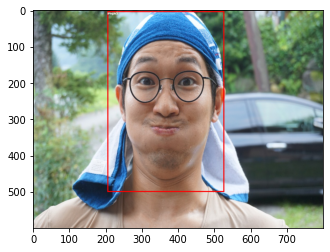

In [28]:
#結果の表示
def show(val_dataloader):
    import matplotlib.pyplot as plt
    from PIL import ImageDraw, ImageFont
    from PIL import Image

    #GPUのキャッシュクリア
    import torch
    torch.cuda.empty_cache()

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
    #device = torch.device('cpu')    
    model.to(device)
    model.eval()#推論モードへ

    images, targets, image_ids = next(iter(val_dataloader))

    images = list(img.to(device) for img in images)

    #推論時は予測を返す
    '''
     - boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, with values of x
          between 0 and W and values of y between 0 and H
        - labels (Int64Tensor[N]): the predicted labels for each image
        - scores (Tensor[N]): the scores or each prediction
    '''
    outputs = model(images)

    for i, image in enumerate(images):

        image = image.permute(1, 2, 0).cpu().numpy()
        image = Image.fromarray((image * 255).astype(np.uint8))

        boxes = outputs[i]["boxes"].data.cpu().numpy()
        scores = outputs[i]["scores"].data.cpu().numpy()
        labels = outputs[i]["labels"].data.cpu().numpy()

        category={0: 'background',1:"saito", 2:"ohnaka",3:"doi",4:'sugai',5:'suzuki'}
        #categoryの記入例    
        #category={0: 'background',1:'person', 2:'traffic light',3: 'train',4: 'traffic sign', 5:'rider', 6:'car', 7:'bike',8: 'motor', 9:'truck', 10:'bus'}

        boxes = boxes[scores >= 0.5].astype(np.int32)
        scores = scores[scores >= 0.5]
        image_id = image_ids[i]

        for i, box in enumerate(boxes):
            draw = ImageDraw.Draw(image)
            label = category[labels[i]]
            draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)

            # ラベルの表示
            from PIL import Image, ImageDraw, ImageFont 
            # fnt = ImageFont.truetype('/content/mplus-1c-black.ttf', 20)
            # fnt = ImageFont.truetype("arial.ttf", 10)#40
            # text_w, text_h = fnt.getsize(label)
            # # draw.rectangle([box[0], box[1], box[0]+text_w, box[1]+text_h], fill="red")
            # draw.text((box[0], box[1]), label, font=fnt, fill='white')
            draw.text((box[0], box[1]), label, fill='white')
            print(label)

        #画像を保存したい時用
        #image.save(f"resample_test{str(i)}.png")

        fig, ax = plt.subplots(1, 1)
        ax.imshow(np.array(image))

    plt.show()


show(val_dataloader)